In [2]:
import sys
sys.path.append('../src')

import loading_json as load
import road_network as rn
import torch
import matplotlib.pyplot as plt

#### Testing how to divide flux across junction without having to optimize anything

n incoming roads, m outgoing roads


Outgoing roads should not discriminate, meaning that flux should, as far as possible, be coming equally from the different roads.
The desired distribution of the influx is known a priori.
Idea, first assume that flux is coming equally from all roads, so for outgoing road j, 1/n part of the capacity is filled with the influx from road i for i = 1,...,n.

After the initial distribution, the outgoing roads might have some extra capacity, and the incoming roads might have some extra influx.
How should this be distributed?



##### Test example: n = 3, m = 2

In [6]:
n = 3
m = 2

def D(rho):
    return min(rho, 0.5)
def S(rho):
    return max(rho, 0.5)

rho_in = [0.6, 0.4, 0.3]
rho_out = [0.6, 0.4]

# Desired distribution of the traffic
alpha = [[0.6, 0.4],
         [0.4, 0.6],
         [0.2, 0.8]]

fluxes = torch.zeros((n, m))

desired_out_fluxes = [0] * m

for j in range(m):
    desired_out_fluxes[j] = sum(alpha[i][j] * rho_in[i] for i in range(n))

print(desired_out_fluxes)



[0.5800000000000001, 0.72]


In [1]:
for i in range(4):
    for _ in range(3):
        for _ in range(2):
            print(i)
            break

0
0
0
1
1
1
2
2
2
3
3
3


In [3]:
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
c = [a, b]
c[1] += 1
b

tensor([5, 6, 7])

In [3]:
a = "left 1"
print(a[:4])

left


In [5]:
a = torch.tensor(3., requires_grad=True)

b = a**2

c = b.clone()

objective = a.clone()**2

torch.autograd.grad(objective, a)[0]

tensor(6.)

In [2]:
a = torch.tensor([-1.,-2.,-4.])
b = torch.tensor([3.,3.,3.])
torch.dot(a, b)
a/4.

tensor([-0.2500, -0.5000, -1.0000])

In [3]:
def test_func(x):
    return x**2*(1-x)

x = torch.tensor([0.5], requires_grad=True)

objective = test_func(x)

f = torch.autograd.grad(objective, x, create_graph=True, allow_unused=True)[0]
f1 = torch.autograd.grad(objective, x, create_graph=True, allow_unused=True)[0]

print(f, f1)

tensor([0.2500], grad_fn=<AddBackward0>) tensor([0.2500], grad_fn=<AddBackward0>)


In [5]:
import numpy as np
print(np.ceil(2/2) - np.ceil(2/2))

0.0


In [4]:
x = torch.tensor([1.] , requires_grad=True)
b = torch.tensor([1.,4.,5.,6.])
d = torch.tensor([2.,3.,1.,2.])

c = torch.sum(torch.max(d, x*b))
print(c)
gradient = torch.autograd.grad(c, x, create_graph=True, allow_unused=True)[0]
print(gradient)

tensor(17., grad_fn=<SumBackward0>)
tensor([15.])


In [5]:
T, roads, junctions = load.read_json('../configs/simple_1-1.json')

1 roads initialized
2 roads initialized
All roads initialized
1 junctions initialized
All junctions initialized


In [6]:
loaded_roads = []
loaded_junctions = []
for r in roads:
    # road = rn.Road(b=r['b'], L = r['L'], N = r['N'], Vmax=float(r['Vmax']),
    #                 scheme=r['Scheme'], limiter="minmod")
    loaded_roads.append(rn.Road(b=r['b'], L = r['L'], N = r['N'], Vmax=float(r['Vmax']),
                    scheme=r['Scheme'], limiter="minmod",
                    initial = r["Init_distr"], inflow = 1.))

for j in junctions:
    loaded_junctions.append(rn.Junction(roads = [loaded_roads[i] for i in j["j_roads"]],
                                        entering = j["entering"], leaving = j["leaving"],
                                        distribution=j["distribution"], redlights=[]))



network = rn.RoadNetwork(loaded_roads, loaded_junctions, T)
# print(loaded_roads[0].dx)
# print(loaded_roads[0].gamma)
# print(loaded_roads[1].dx)
# print(loaded_roads[1].gamma)

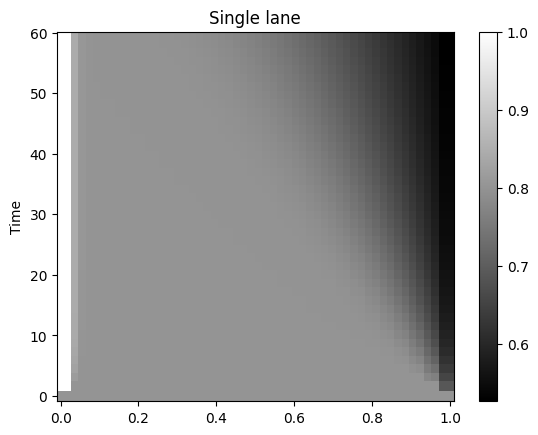

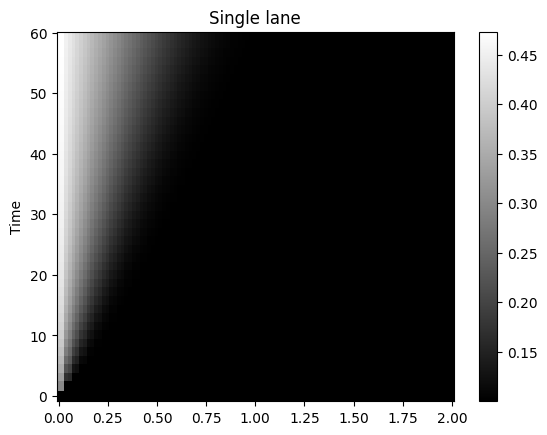

In [7]:
history = network.solve_cons_law()

#history[0]

times = list(history[0].keys())

for i in range(len(history)):
    x = torch.linspace(0,roads[i]['b'], len(history[i][0]))
    # print(len(x))
    full_array = []
    for t in times:
        #print(key)
        #print(len(history[i][t].detach()))
        full_array.append(history[i][t].detach())
        # print(sum(history[i][t].detach()[2:-2]))

    fig = plt.pcolor(x, times, full_array, cmap="gray")
    plt.colorbar(fig)
    plt.title("Single lane")
    plt.ylabel("Time")
    plt.show()

In [9]:
network.roads[0].queue_length

AttributeError: 'Road' object has no attribute 'queue_length'

In [39]:
a = torch.linspace(0,1,20)
interval = [0.2, 0.5]

[i for i in a if interval[0] <= i <= interval[1]]

[tensor(0.2105),
 tensor(0.2632),
 tensor(0.3158),
 tensor(0.3684),
 tensor(0.4211),
 tensor(0.4737)]

In [35]:
def test_func(x1,x2,x3,x4):
    return x1**3 * (x2 - x3 / x4**2) + x1**4

x1 = torch.tensor([0.1], requires_grad=True)
x2 = torch.tensor([0.33], requires_grad=True)
x3 = torch.tensor([12.145], requires_grad=True)
x4 = torch.tensor([22.1], requires_grad=True)



hessian = torch.autograd.functional.hessian(test_func, (x1, x2, x3, x4))
H = torch.zeros((4,4))
J = torch.zeros(4)
manual_hessian = torch.zeros((4,4))
objective = test_func(x1, x2, x3, x4)
vars = [x1, x2, x3, x4]
for i in range(len(vars)):
    first_derivative = torch.autograd.grad(objective, vars[i], create_graph=True, allow_unused=True)[0]
    if first_derivative:
        J[i] = first_derivative
    for j in range(len(vars)):
        second_derivative = torch.autograd.grad(first_derivative, vars[j], create_graph=True, allow_unused=True)[0]
        if second_derivative:
            manual_hessian[i,j] = second_derivative
        H[i,j] = hessian[i][j][0]
print(manual_hessian)
print(H)
print(J)

tensor([[ 3.0308e-01,  3.0000e-02, -6.1424e-05,  6.7511e-05],
        [ 3.0000e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-6.1424e-05,  0.0000e+00,  0.0000e+00,  1.8529e-07],
        [ 6.7511e-05,  0.0000e+00,  1.8529e-07, -3.0548e-07]],
       grad_fn=<CopySlices>)
tensor([[ 3.0308e-01,  3.0000e-02, -6.1424e-05,  6.7511e-05],
        [ 3.0000e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-6.1424e-05,  0.0000e+00,  0.0000e+00,  1.8529e-07],
        [ 6.7511e-05,  0.0000e+00,  1.8529e-07, -3.0548e-07]])
tensor([ 1.3154e-02,  1.0000e-03, -2.0475e-06,  2.2504e-06],
       grad_fn=<CopySlices>)


In [ ]:
speeds = [14.3889, 14.8889, ]
objectives = [0.0002, 0.0005, 0.0009, ]